In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#συνδέση του Google Drive στο Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Path του αρχείου δεδομένων
path = "/content/drive/MyDrive/Datamining_Project/household_power_consumption.txt" #φορτωμα αρχειου

# Διαβάζουμε με: sep=";" (όπως είναι στο UCI dataset)
df = pd.read_csv(
    path,
    sep=";",
    na_values=["", "NA", "N/A", "?"]
)
# Γρήγορος οπτικός έλεγχος: κεφαλίδες και πρώτες γραμμές
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [3]:
#ελεγχος δομης αρχείου και "βρωμιας"
print(df.shape)
display(df.info())

# Πόσες ελλιπείς τιμές ανά στήλη (Top 10) ώστε να τεκμηριώσουμε την ανάγκη cleaning
missing = df.isna().sum().sort_values(ascending=False)
display(missing.head(10))


(2075259, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    float64
 3   Global_reactive_power  float64
 4   Voltage                float64
 5   Global_intensity       float64
 6   Sub_metering_1         float64
 7   Sub_metering_2         float64
 8   Sub_metering_3         float64
dtypes: float64(7), object(2)
memory usage: 142.5+ MB


None

,0
Global_active_power,25979
Sub_metering_2,25979
Global_reactive_power,25979
Voltage,25979
Global_intensity,25979
Sub_metering_3,25979
Sub_metering_1,25979
Date,0
Time,0


In [4]:
#μετατροπή Date+Time σε datetime index  (βασικό βήμα για resampling)
df["Datetime"] = pd.to_datetime(
    df["Date"] + " " + df["Time"],
    format="%d/%m/%Y %H:%M:%S",
    # errors="coerce" σημαίνει ότι οτιδήποτε δεν "διαβάζεται" γίνεται NaT (άρα το πιάνουμε και το πετάμε μετά)
    errors="coerce"
)

# Αφαιρούμε γραμμές που δεν μετατράπηκαν σωστά σε datetime
df = df.dropna(subset=["Datetime"]).copy()
# Ορίζουμε το Datetime ως index και ταξινομούμε
df = df.set_index("Datetime").sort_index()

# αφαιρούμε τις αρχικές Date/Time για να μην "διπλομετράμε" πληροφορία
df = df.drop(columns=["Date", "Time"])

df.head()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [5]:
#μετατροπή στηλών σε αριθμητικές->Οι στήλες κατανάλωσης/τάσης/έντασης πρέπει να είναι floats(από strings -> floats).
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [6]:
# Resample/align σε 1 λεπτό (σταθερή χρονοσειρά) + συμπλήρωση ελλείψεων
# Εδώ φτιάχνουμε πλήρη minute-level σειρά και ευθυγραμμίζουμε όλα τα χαρακτηριστικά.
df_1min = df.resample("1min").mean()

print("Αρχικές γραμμές:", df.shape[0])
print("Μετά το 1min resample:", df_1min.shape[0])

# Έλεγχος ποσοστού NaN ανά στήλη μετά το resample
df_1min.isna().mean().sort_values(ascending=False).head(10)

Αρχικές γραμμές: 2075259
Μετά το 1min resample: 2075259


,0
Global_active_power,0.012518
Global_reactive_power,0.012518
Voltage,0.012518
Global_intensity,0.012518
Sub_metering_1,0.012518
Sub_metering_2,0.012518
Sub_metering_3,0.012518


In [7]:
#missing values, Time interpolation για μικρά κενά, forward fill (ffill) για ό,τι απέμεινε,
df_clean = df_1min.copy()

# Interpolation με βάση τον χρόνο
# limit=60 -> γεμίζει κενά έως 60 λεπτά συνεχόμενα (ρύθμιση ασφαλείας)
df_clean = df_clean.interpolate(method="time", limit=60)

# Συμπλήρωση ό,τι έμεινε
df_clean = df_clean.ffill().bfill()

# Έλεγχος ότι δεν έμειναν NaN
df_clean.isna().sum().sum()

np.int64(0)

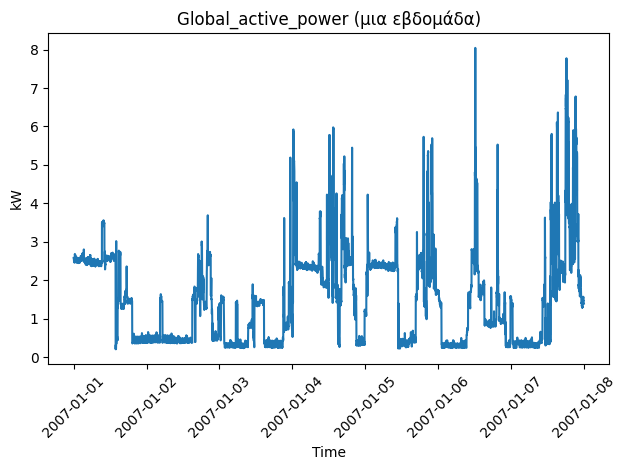

In [8]:
#Πλοτάρω λίγες μέρες να δω ότι η σειρά είναι ok -> Γραφικός έλεγχος
#Διάλεγω ένα μικρό διάστημα για plot
# Οπτικός έλεγχος για να δούμε ότι η χρονοσειρά είναι ομαλή και λογική μετά το cleaning.
sample = df_clean.loc["2007-01-01":"2007-01-07", "Global_active_power"]

plt.figure()
plt.plot(sample.index, sample.values)
plt.title("Global_active_power (μια εβδομάδα)")
plt.xlabel("Time")
plt.ylabel("kW")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

True    1442
Name: count, dtype: int64


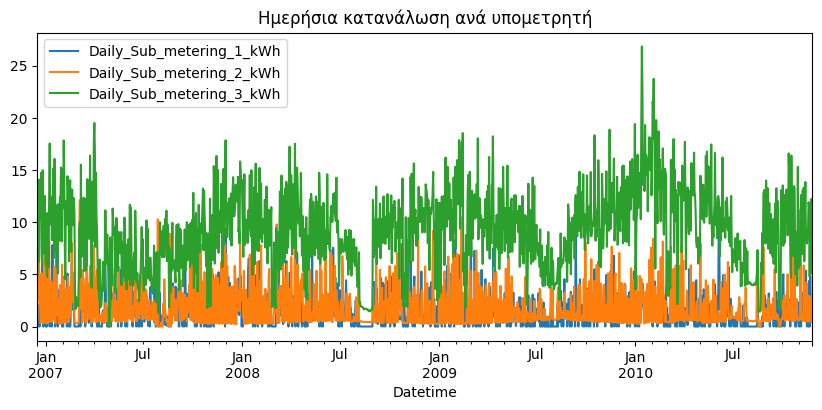

(            Daily_total_kWh  Daily_Sub_metering_1_kWh  \
 Datetime                                                
 2006-12-16        20.152933                     0.000   
 2006-12-17        56.507667                     2.033   
 2006-12-18        36.730433                     1.063   
 2006-12-19        27.769900                     0.839   
 2006-12-20        37.095800                     0.000   
 
             Daily_Sub_metering_2_kWh  Daily_Sub_metering_3_kWh  Sub_sum_kWh  
 Datetime                                                                     
 2006-12-16                     0.546                     4.926        5.472  
 2006-12-17                     4.187                    13.341       19.561  
 2006-12-18                     2.621                    14.018       17.702  
 2006-12-19                     7.602                     6.197       14.638  
 2006-12-20                     2.648                    14.063       16.711  ,
 (1442, 5))

In [9]:
#φτιάχνω και ένα daily dataframe, Στο dataset το Global_active_power είναι σε kW -> για να βγάλω ενέργεια σε kWh ανά ημέρα, κάνω: kW * (1/60 ώρα) και μετά sum στη μέρα
#Μετατροπη Ημερήσιας ενέργειας (kWh) από kW ανά λεπτό
daily_kwh = df_clean["Global_active_power"].resample("1D").sum() / 60.0
daily = daily_kwh.to_frame(name="Daily_total_kWh")

# Sub_metering_* δίνονται σε Wh ανά λεπτό (στο dataset). Άρα:
# sum(Wh ανά ημέρα) / 1000 => kWh ανά ημέρα
sub_cols = ["Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]
daily_sub = df_clean[sub_cols].resample("1D").sum() / 1000.0
daily_sub = daily_sub.add_prefix("Daily_").add_suffix("_kWh")
daily = daily.join(daily_sub)

# Έλεγχος συνέπειας:Το άθροισμα των υπομετρητών ιδανικά είναι <= συνολική ενέργεια.
daily["Sub_sum_kWh"] = daily["Daily_Sub_metering_1_kWh"] + daily["Daily_Sub_metering_2_kWh"] + daily["Daily_Sub_metering_3_kWh"]

daily.columns

# Πρέπει σχεδόν πάντα: Sub_sum_kWh <= Daily_total_kWh
check = (daily["Sub_sum_kWh"] <= daily["Daily_total_kWh"])
print(check.value_counts())

#κατανάλωση ανά υπομετρητή
daily[
    ["Daily_Sub_metering_1_kWh",
     "Daily_Sub_metering_2_kWh",
     "Daily_Sub_metering_3_kWh"]
].plot(figsize=(10,4))
plt.title("Ημερήσια κατανάλωση ανά υπομετρητή")
plt.show()


daily.head(), daily.shape


In [10]:
#Αποθήκευση “καθαρού” αποτελέσματος-> Αποθηκεύουμε: minute-level καθαρό dataset, daily dataset
df_clean.to_parquet("power_1min_clean.parquet")
daily.to_parquet("power_daily.parquet")

In [11]:
# προσθέτουμε στο daily dataframe:ημέρα εβδομάδας (0=Δευτέρα), όνομα ημέρας, is_weekend (0/1)
# Ημέρα εβδομάδας / Σαββατοκύριακο
daily = daily.copy()

daily["day_of_week"] = daily.index.dayofweek # 0=Δευτέρα ... 6=Κυριακή
daily["day_name"] = daily.index.day_name()
daily["is_weekend"] = (daily["day_of_week"] >= 5).astype(int)

daily.head()


,Daily_total_kWh,Daily_Sub_metering_1_kWh,Daily_Sub_metering_2_kWh,Daily_Sub_metering_3_kWh,Sub_sum_kWh,day_of_week,day_name,is_weekend
Datetime,,,,,,,,
2006-12-16,20.152933,0.000,0.546,4.926,5.472,5,Saturday,1
2006-12-17,56.507667,2.033,4.187,13.341,19.561,6,Sunday,1
2006-12-18,36.730433,1.063,2.621,14.018,17.702,0,Monday,0
2006-12-19,27.769900,0.839,7.602,6.197,14.638,1,Tuesday,0
2006-12-20,37.095800,0.000,2.648,14.063,16.711,2,Wednesday,0


In [12]:
#Θα θεωρήσουμε:Νύχτα = 00:00 – 06:00, από το minute-level dataframe, φιλτράρουμε ώρες 0–5 και υπολογίζουμε kWh ανά ημέρα
# Δημιουργία ώρας
df_clean["hour"] = df_clean.index.hour

# Νυχτερινή κατανάλωση (00:00 - 06:00)
night_df = df_clean[df_clean["hour"] < 6]

night_kwh = night_df["Global_active_power"].resample("1D").sum() / 60.0
night_kwh.name = "Nighttime_kWh"

daily = daily.join(night_kwh)

daily.head()


,Daily_total_kWh,Daily_Sub_metering_1_kWh,Daily_Sub_metering_2_kWh,Daily_Sub_metering_3_kWh,Sub_sum_kWh,day_of_week,day_name,is_weekend,Nighttime_kWh
Datetime,,,,,,,,,
2006-12-16,20.152933,0.000,0.546,4.926,5.472,5,Saturday,1,NaN
2006-12-17,56.507667,2.033,4.187,13.341,19.561,6,Sunday,1,12.693833
2006-12-18,36.730433,1.063,2.621,14.018,17.702,0,Monday,0,2.503900
2006-12-19,27.769900,0.839,7.602,6.197,14.638,1,Tuesday,0,2.460200
2006-12-20,37.095800,0.000,2.648,14.063,16.711,2,Wednesday,0,2.364600


In [13]:
# Peak hour power = μέγιστη μέση ωριαία ισχύς μέσα στη μέρα
# Μέση ισχύς ανά ώρα και μετά παίρνουμε το max ανά ημέρα (peak).
hourly_mean_power = df_clean["Global_active_power"].resample("1H").mean()

# Peak hour power ανά ημέρα
peak_hour_power = hourly_mean_power.resample("1D").max()
peak_hour_power.name = "Peak_hour_power"

daily = daily.join(peak_hour_power)

daily.head()


/tmp/ipython-input-3980435205.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_mean_power = df_clean["Global_active_power"].resample("1H").mean()


,Daily_total_kWh,Daily_Sub_metering_1_kWh,Daily_Sub_metering_2_kWh,Daily_Sub_metering_3_kWh,Sub_sum_kWh,day_of_week,day_name,is_weekend,Nighttime_kWh,Peak_hour_power
Datetime,,,,,,,,,,
2006-12-16,20.152933,0.000,0.546,4.926,5.472,5,Saturday,1,NaN,4.222889
2006-12-17,56.507667,2.033,4.187,13.341,19.561,6,Sunday,1,12.693833,3.697100
2006-12-18,36.730433,1.063,2.621,14.018,17.702,0,Monday,0,2.503900,3.050567
2006-12-19,27.769900,0.839,7.602,6.197,14.638,1,Tuesday,0,2.460200,3.879033
2006-12-20,37.095800,0.000,2.648,14.063,16.711,2,Wednesday,0,2.364600,3.646067


In [14]:
#Υπολογίζουμε κατανάλωση μόνο για Σαββατοκύριακα
# Εδώ το κρατάμε ως "ενέργεια μόνο όταν είναι weekend αλλιώς 0".
daily["Weekend_kWh"] = daily["Daily_total_kWh"] * daily["is_weekend"]

daily.head()


,Daily_total_kWh,Daily_Sub_metering_1_kWh,Daily_Sub_metering_2_kWh,Daily_Sub_metering_3_kWh,Sub_sum_kWh,day_of_week,day_name,is_weekend,Nighttime_kWh,Peak_hour_power,Weekend_kWh
Datetime,,,,,,,,,,,
2006-12-16,20.152933,0.000,0.546,4.926,5.472,5,Saturday,1,NaN,4.222889,20.152933
2006-12-17,56.507667,2.033,4.187,13.341,19.561,6,Sunday,1,12.693833,3.697100,56.507667
2006-12-18,36.730433,1.063,2.621,14.018,17.702,0,Monday,0,2.503900,3.050567,0.000000
2006-12-19,27.769900,0.839,7.602,6.197,14.638,1,Tuesday,0,2.460200,3.879033,0.000000
2006-12-20,37.095800,0.000,2.648,14.063,16.711,2,Wednesday,0,2.364600,3.646067,0.000000


In [15]:
#θα ορισω: Winter: (12,1,2) Spring: (3,4,5) Summer: (6,7,8) Autumn: (9,10,11)
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

daily["season"] = daily.index.month.map(get_season)

daily.head()


,Daily_total_kWh,Daily_Sub_metering_1_kWh,Daily_Sub_metering_2_kWh,Daily_Sub_metering_3_kWh,Sub_sum_kWh,day_of_week,day_name,is_weekend,Nighttime_kWh,Peak_hour_power,Weekend_kWh,season
Datetime,,,,,,,,,,,,
2006-12-16,20.152933,0.000,0.546,4.926,5.472,5,Saturday,1,NaN,4.222889,20.152933,Winter
2006-12-17,56.507667,2.033,4.187,13.341,19.561,6,Sunday,1,12.693833,3.697100,56.507667,Winter
2006-12-18,36.730433,1.063,2.621,14.018,17.702,0,Monday,0,2.503900,3.050567,0.000000,Winter
2006-12-19,27.769900,0.839,7.602,6.197,14.638,1,Tuesday,0,2.460200,3.879033,0.000000,Winter
2006-12-20,37.095800,0.000,2.648,14.063,16.711,2,Wednesday,0,2.364600,3.646067,0.000000,Winter


In [16]:
#Ελέγχω:NaN, στατιστικά, ότι όλα “βγάζουν νόημα”
#Τεκμηρίωση ότι τα features είναι πλήρη και λογικά.
daily.info()
daily.describe()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1442 entries, 2006-12-16 to 2010-11-26
Freq: D
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily_total_kWh           1442 non-null   float64
 1   Daily_Sub_metering_1_kWh  1442 non-null   float64
 2   Daily_Sub_metering_2_kWh  1442 non-null   float64
 3   Daily_Sub_metering_3_kWh  1442 non-null   float64
 4   Sub_sum_kWh               1442 non-null   float64
 5   day_of_week               1442 non-null   int32  
 6   day_name                  1442 non-null   object 
 7   is_weekend                1442 non-null   int64  
 8   Nighttime_kWh             1441 non-null   float64
 9   Peak_hour_power           1442 non-null   float64
 10  Weekend_kWh               1442 non-null   float64
 11  season                    1442 non-null   object 
dtypes: float64(8), int32(1), int64(1), object(2)
memory usage: 140.8+ KB


,Daily_total_kWh,Daily_Sub_metering_1_kWh,Daily_Sub_metering_2_kWh,Daily_Sub_metering_3_kWh,Sub_sum_kWh,day_of_week,is_weekend,Nighttime_kWh,Peak_hour_power,Weekend_kWh
count,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1441.000000,1442.000000,1442.000000
mean,26.056761,1.598806,1.853658,9.235660,12.688124,3.000000,0.285714,3.033082,2.847893,8.334052
std,10.058666,1.589069,2.088267,3.802919,5.501466,2.000694,0.451911,2.106748,1.066953,14.696637
min,4.106612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.992000,0.171109,0.000000
25%,19.444358,0.579750,0.430000,6.646250,9.076250,1.000000,0.000000,2.051867,2.154808,0.000000
50%,25.708100,1.110500,0.684000,9.262500,12.242000,3.000000,0.000000,2.492267,2.803800,0.000000
75%,31.565983,2.201750,2.732000,11.740000,16.115500,5.000000,1.000000,2.999067,3.483675,15.289225
max,79.556433,11.224000,12.109000,26.835527,32.485112,6.000000,1.000000,17.580733,6.560533,79.556433


In [17]:
#Αποθήκευση feature dataset
# Αυτό είναι το dataset που θα χρησιμοποιηθεί για Classification / Regression / Clustering / Rules
daily.to_parquet(
    "/content/drive/MyDrive/Datamining_Project/power_daily_features.parquet"
)